In [1]:
#Define project

In [78]:
# Part 1 Modules we need
import time
import random
import math
import re
from dataclasses import dataclass, asdict
from typing import List, Optional, Tuple
from pathlib import Path
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
from bs4 import BeautifulSoup, FeatureNotFound
from urllib.parse import urljoin, urlparse, parse_qs, urlencode, urlunparse

# Selenium fallback 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk; nltk.download('vader_lexicon')

# Word cloud modules
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Parser fallback so BS works even if lxml isn't installed
try:
    import lxml  # noqa: F401  # just to check availability
    _BS_PARSER = "lxml"
except Exception:
    _BS_PARSER = "html.parser"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ando\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Data Collection Pt 2 (URL)
DEFAULT_HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/122.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

REQUEST_TIMEOUT = 20
PAUSE_RANGE = (1.5, 3.5)

@dataclass
class Review:
    asin: str
    page: int
    review_id: Optional[str]
    title: str
    rating: Optional[float]
    author: str
    date_text: str
    body: str
    verified_purchase: bool
    helpful_votes: int
    variant: str

def parse_reviews_from_html(html: str, asin: str, page: int) -> List[Review]:
    # Use whichever parser you set; fall back handled elsewhere
    try:
        _ = _BS_PARSER  # ensuring the variable exists
    except NameError:
        # simple fallback; OK if we didn't set _BS_PARSER earlier
        _BS_PARSER = "html.parser"

    soup = BeautifulSoup(html, _BS_PARSER)
    review_divs = soup.select('div[data-hook="review"], div[id^="customer_review-"]')
    results: List[Review] = []

    for div in review_divs:
        rid = div.get("id")

        title_el = div.select_one('a[data-hook="review-title"] span')
        title = title_el.get_text(strip=True) if title_el else ""

        rating_el = (div.select_one('i[data-hook="review-star-rating"] span')
                     or div.select_one('i[data-hook="cmps-review-star-rating"] span'))
        rating = None
        if rating_el:
            m = re.search(r"([\d.]+)\s+out of\s+5", rating_el.get_text(strip=True))
            if m:
                try:
                    rating = float(m.group(1))
                except:
                    rating = None

        author_el = div.select_one('span.a-profile-name')
        author = author_el.get_text(strip=True) if author_el else ""

        date_el = div.select_one('span[data-hook="review-date"]')
        date_text = date_el.get_text(strip=True) if date_el else ""

        body_el = (div.select_one('span[data-hook="review-body"] span')
                   or div.select_one('span[data-hook="review-body"]'))
        body = body_el.get_text(" ", strip=True) if body_el else ""

        vp_el = div.select_one('span[data-hook="avp-badge"]')
        verified_purchase = bool(vp_el and "Verified Purchase" in vp_el.get_text())

        helpful_el = div.select_one('span[data-hook="helpful-vote-statement"]')
        helpful_votes = 0
        if helpful_el:
            txt = helpful_el.get_text(strip=True).lower()
            if txt.startswith("one"):
                helpful_votes = 1
            else:
                m2 = re.search(r"(\d[\d,]*)", txt)
                helpful_votes = int(m2.group(1).replace(",", "")) if m2 else 0

        variant_el = (div.select_one('a[data-hook="format-strip"]')
                      or div.select_one('span[data-hook="format-strip"]'))
        variant = variant_el.get_text(" ", strip=True) if variant_el else ""

        results.append(Review(
            asin=asin,
            page=page,
            review_id=rid,
            title=title,
            rating=rating,
            author=author,
            date_text=date_text,
            body=body,
            verified_purchase=verified_purchase,
            helpful_votes=helpful_votes,
            variant=variant
        ))

    return results

def _looks_like_antibot(html: str) -> bool:
    text = html.lower()
    triggers = [
        "sorry, we just need to make sure you're not a robot",
        "enter the characters you see below",
        "to discuss automated access",
        "api-services-support@amazon.com",
        "Type the characters you see in this image".lower()
    ]
    return any(t in text for t in triggers)

def get_canonical_reviews_url(asin: str, country: str = "com") -> Optional[str]:
    """
    Visit the *product* page and extract Amazon's 'See all reviews' link.
    If not found or blocked, return a sensible base reviews URL as fallback.
    """
    product_url = f"https://www.amazon.{country}/dp/{asin}"
    s = requests.Session()
    s.headers.update(DEFAULT_HEADERS)

    resp = s.get(product_url, timeout=REQUEST_TIMEOUT, allow_redirects=True)
    if resp.status_code != 200:
        print(f"[Requests] Product page status {resp.status_code} for {product_url}")
        # Fallback to base pattern
        return f"https://www.amazon.{country}/product-reviews/{asin}/"
    if "captcha" in resp.text.lower() or _looks_like_antibot(resp.text):
        print("[Requests] Captcha/anti-bot detected on product page; using fallback base URL.")
        return f"https://www.amazon.{country}/product-reviews/{asin}/"

    soup = BeautifulSoup(resp.text, _BS_PARSER)

    # Preferred selector (when Amazon shows a review widget on the product page)
    link = soup.select_one('a[data-hook="see-all-reviews-link-foot"]')

    # Fallback: any link that looks like /product-reviews/<ASIN>/
    if not link:
        for a in soup.select("a[href]"):
            href = a.get("href", "")
            if f"/product-reviews/{asin}" in href:
                link = a
                break

    if not link:
        print("[Requests] Could not find a 'See all reviews' link on product page; using fallback base URL.")
        return f"https://www.amazon.{country}/product-reviews/{asin}/"

    href = link.get("href")
    abs_url = urljoin(product_url, href)
    return abs_url

def add_or_update_query(url: str, **params) -> str:
    """
    Add or overwrite query params on a URL.
    """
    parsed = urlparse(url)
    q = parse_qs(parsed.query)
    for k, v in params.items():
        q[k] = [str(v)]
    new_query = urlencode({k: v[0] for k, v in q.items()})
    return urlunparse(parsed._replace(query=new_query))

def build_reviews_page_url(base_reviews_url: str, page: int) -> str:
    # Ensuring we request "all reviews" and the sort we want; then setting the pageNumber
    url = add_or_update_query(base_reviews_url,
                              reviewerType="all_reviews",
                              sortBy="recent",
                              pageNumber=page)
    return url

In [5]:
# Part 3 Fetching right HTML

def fetch_reviews_requests_v2(asin: str, pages: int = 3, country: str = "com") -> List[Review]:
    s = requests.Session()
    s.headers.update(DEFAULT_HEADERS)

    base = get_canonical_reviews_url(asin, country=country)
    if not base:
        print("[Requests] Could not discover reviews URL. Try prefer='selenium' or check ASIN/country.")
        return []

    all_reviews: List[Review] = []

    for page in range(1, pages + 1):
        url = build_reviews_page_url(base, page)
        s.headers["Referer"] = base

        resp = s.get(url, timeout=REQUEST_TIMEOUT)
        if resp.status_code != 200:
            print(f"[Requests] Page {page}: status {resp.status_code}")
            break
        if "captcha" in resp.text.lower() or _looks_like_antibot(resp.text):
            print(f"[Requests] Page {page}: captcha/anti-bot encountered.")
            break
        test_soup = BeautifulSoup(resp.text, _BS_PARSER)
        if not test_soup.select('div[data-hook="review"]'):
            print("[Debug] No review blocks found on this page.")
            print("[Debug] Status:", resp.status_code)
            print("[Debug] First 300 chars:", resp.text[:300].lower())
            
        ct = resp.headers.get("content-type", "")
        if "text/html" not in ct:
            print(f"[Requests] Unexpected content-type on page {page}: {ct}")

        page_reviews = parse_reviews_from_html(resp.text, asin=asin, page=page)  # ensure this uses _BS_PARSER
        print(f"[Requests] Page {page}: parsed {len(page_reviews)} reviews.")
        all_reviews.extend(page_reviews)

        time.sleep(random.uniform(*PAUSE_RANGE))
        if len(page_reviews) == 0:
            break

    return all_reviews

In [6]:
# Part 4 Trying to close cookies/location banners
def _dismiss_overlays(driver):
    """Best-effort clicks for cookie/location banners; safe no-ops if not present."""
    try:
        # Common cookie banner id
        btn = WebDriverWait(driver, 3).until(
            EC.element_to_be_clickable((By.ID, "sp-cc-accept"))
        )
        btn.click()
    except Exception:
        pass
    try:
        # Variants by text
        for sel in [
            "//input[@name='accept']",
            "//button[normalize-space()='Accept Cookies']",
            "//button[normalize-space()='Continue']",
        ]:
            elems = driver.find_elements(By.XPATH, sel)
            if elems:
                elems[0].click()
                break
    except Exception:
        pass
    try:
        # Closing generic modal
        close_btns = driver.find_elements(By.CSS_SELECTOR, "button[aria-label='Close']")
        if close_btns:
            close_btns[0].click()
    except Exception:
        pass

def _on_login_page(driver) -> bool:
    """Detect Amazon Sign-In / MFA screens."""
    return any([
        driver.find_elements(By.ID, "ap_email"),
        driver.find_elements(By.NAME, "email"),
        driver.find_elements(By.ID, "ap_password"),
        driver.find_elements(By.NAME, "password"),
        driver.find_elements(By.ID, "auth-mfa-otpcode"),
        driver.find_elements(By.XPATH, "//h1[contains(., 'Sign-In') or contains(., 'Sign in')]"),
    ])

def _wait_for_manual_login(driver, target_ready_check, timeout=300) -> bool:
    """
    Give the user time to complete login + 2FA.
    target_ready_check: a lambda that returns True when reviews are visible.
    """
    start = time.time()
    print(f"[Selenium] Login detected. You have up to {timeout}s to complete login + 2FA. "
          f"Leave this window focused; I’ll resume automatically.")
    while time.time() - start < timeout:
        # success conditions: reviews visible OR we navigated away from login
        if target_ready_check():
            return True
        # abort if captcha is shown during login
        if driver.find_elements(By.CSS_SELECTOR, "form[action*='captcha']"):
            print("[Selenium] Captcha detected during login; cannot proceed.")
            return False
        time.sleep(2)
    print("[Selenium] Timed out waiting for manual login/2FA.")
    return False

In [59]:
# Part 5 Selenium backup (ends up being main driver)
def _direct_reviews_url(asin: str, country: str, page: int) -> str:
    base = f"https://www.amazon.{country}/product-reviews/{asin}/"
    return add_or_update_query(base, reviewerType="all_reviews", sortBy="recent", pageNumber=page)
    
# Making our driver less botty to be able to reduce automation fingerprints     
def create_driver(headless: bool = False):
    opts = ChromeOptions()
    if headless:
        opts.add_argument("--headless=new")

    # Always-on flags
    opts.add_argument("--disable-gpu")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--window-size=1200,1800")
    opts.add_argument(f'--user-agent={DEFAULT_HEADERS["User-Agent"]}')
    opts.add_experimental_option("excludeSwitches", ["enable-automation"])
    opts.add_experimental_option("useAutomationExtension", False)
    opts.add_argument("--disable-blink-features=AutomationControlled")

    # Prefer a cache directory inside your project to avoid AV in %USERPROFILE%\.wdm
    cache_dir = Path.cwd() / "wdm_cache"
    cache_dir.mkdir(exist_ok=True)

    try:
        # Trying webdriver_manager first, but cache to a safe local folder
        service = Service(ChromeDriverManager(path=str(cache_dir)).install())
        driver = webdriver.Chrome(service=service, options=opts)
    except Exception as e:
        print(f"[Warn] webdriver-manager failed ({e}); falling back to Selenium Manager.")
        # Selenium Manager auto-resolves the driver; no manual download/cache
        driver = webdriver.Chrome(options=opts)

    driver.implicitly_wait(2)
    return driver

def _first_review_id(driver) -> Optional[str]:
    try:
        el = driver.find_elements(By.CSS_SELECTOR, "div[data-hook='review'], div[id^='customer_review-']")
        if el:
            return el[0].get_attribute("id") or ""
    except Exception:
        pass
    return None

def fetch_reviews_selenium(asin: str, pages: int = 3, country: str = "com", headless: bool = True) -> List[Review]:
    driver = create_driver(headless=headless)
    if driver is None:
        raise RuntimeError("create_driver() returned None; check headless/indentation.")
    all_reviews: list[Review] = []
    seen_ids = set()  # preventing duplicates across pages
    try:
        driver.execute_cdp_cmd("Network.enable", {})
        driver.execute_cdp_cmd("Network.setExtraHTTPHeaders", {"headers": {"Referer": f"https://www.amazon.{country}/dp/{asin}"}})
    except Exception:
        pass

    try:
        for page in range(1, pages + 1):
            url = _direct_reviews_url(asin, country, page)

            if page == 1:
                driver.get(url)
            else:
                # Click the "Next" pagination control instead of GET by URL
                prev_first = _first_review_id(driver)
                # If there is no <a> inside li.a-last, we are likely at the last page
                last_li = driver.find_element(By.CSS_SELECTOR, "li.a-last")
                anchors = last_li.find_elements(By.TAG_NAME, "a")
                if not anchors:
                    print("[Selenium] 'Next' is disabled or missing; stopping.")
                    break
                
                next_btn = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, "li.a-last a"))
                )
                driver.execute_script("arguments[0].scrollIntoView({block:'center'});", next_btn)
                driver.execute_script("arguments[0].click();", next_btn)

                # Waiting until first review changes (confirming we’re on a new page)
                WebDriverWait(driver, 20).until(
                    lambda d: (_fid := _first_review_id(d)) and _fid != prev_first
                )

            # Optional quick overlay cleanup after navigation
            _dismiss_overlays(driver)

            # Waiting until either reviews render OR an interstitial is detected
            try:
                WebDriverWait(driver, 25).until(
                    EC.any_of(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-hook='review']")),
                        EC.presence_of_element_located((By.ID, "cm_cr-review_list")),
                        EC.presence_of_element_located((By.CSS_SELECTOR, "form[action*='captcha']")),
                        EC.presence_of_element_located((By.XPATH, "//*[contains(., \"make sure you're not a robot\")]"))
                    )
                )
            except TimeoutException:
                _dismiss_overlays(driver)
                WebDriverWait(driver, 20).until(
                    EC.any_of(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-hook='review']")),
                        EC.presence_of_element_located((By.ID, "cm_cr-review_list")),
                        EC.presence_of_element_located((By.CSS_SELECTOR, "form[action*='captcha']")),
                        EC.presence_of_element_located((By.XPATH, "//*[contains(., \"make sure you're not a robot\")]"))
                    )
                )

            # If captcha, we bail gracefully
            if driver.find_elements(By.CSS_SELECTOR, "form[action*='captcha']"):
                print("[Selenium] Captcha/anti-bot page detected; stopping Selenium scrape for this run.")
                break
            
            try:
                current = driver.find_element(By.CSS_SELECTOR, "li.a-selected").text.strip()
                print(f"[Selenium] Pagination shows selected page: {current}")
            except Exception:
                pass
                
            # Inspect DOM count (helps to confirm new page)
            rev_els = driver.find_elements(By.CSS_SELECTOR, "div[data-hook='review'], div[id^='customer_review-']")
            if len(rev_els) == 0:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
            print(f"[Selenium] DOM shows {len(rev_els)} reviews on page {page} before parse.")

            # Parse
            html = driver.page_source
            page_reviews = parse_reviews_from_html(html, asin=asin, page=page)
            # De-dup across pages using review_id
            unique = [r for r in page_reviews if r.review_id and r.review_id not in seen_ids]
            for r in unique:
                if r.review_id:
                    seen_ids.add(r.review_id)

            print(f"[Selenium] Page {page}: parsed {len(page_reviews)} reviews, {len(unique)} new.")
            all_reviews.extend(unique)

            time.sleep(random.uniform(*PAUSE_RANGE))

            # Stopping early if we didn't get anything new (likely end or stuck)
            if len(unique) == 0:
                print("[Selenium] No new reviews on this page; stopping.")
                break
    finally:
        driver.quit()

    return all_reviews

In [60]:
# Part 6 Main scraper
def scrape_amazon_reviews(asin: str, pages: int = 5, country: str = "com", prefer: str = "requests") -> pd.DataFrame:
    reviews: List[Review] = []

    if prefer == "requests":
        reviews = fetch_reviews_requests_v2(asin=asin, pages=pages, country=country)
        if not reviews:
            print("[Info] No reviews via Requests; switching to Selenium.")
            reviews = fetch_reviews_selenium(asin=asin, pages=pages, country=country, headless=False)

    elif prefer == "selenium":
        reviews = fetch_reviews_selenium(asin=asin, pages=pages, country=country, headless=False)

    else:
        raise ValueError("prefer must be one of: 'requests', 'selenium'")

    if not reviews:
        cols = ["asin","page","review_id","title","rating","author","date_text",
                "body","verified_purchase","helpful_votes","variant"]
        return pd.DataFrame(columns=cols)

    return pd.DataFrame([asdict(r) for r in reviews])


if __name__ == "__main__":
    # Replace with target ASIN (Boba Protein)
    ASIN = "B07HRJ2VPK"   
    df_reviews = scrape_amazon_reviews(asin=ASIN, pages=15, country="com", prefer="selenium")

    # Save for sentiment pipeline
    out_path = f"amazon_reviews_{ASIN}.csv"
    df_reviews.to_csv(out_path, index=False, encoding="utf-8")
    print(f"Saved {len(df_reviews)} reviews to {out_path}")

[Warn] webdriver-manager failed (ChromeDriverManager.__init__() got an unexpected keyword argument 'path'); falling back to Selenium Manager.
[Selenium] DOM shows 10 reviews on page 1 before parse.
[Selenium] Page 1: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 2 before parse.
[Selenium] Page 2: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 3 before parse.
[Selenium] Page 3: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 4 before parse.
[Selenium] Page 4: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 5 before parse.
[Selenium] Page 5: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 6 before parse.
[Selenium] Page 6: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 7 before parse.
[Selenium] Page 7: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 8 before parse.
[Selenium] Page 8: parsed 10 reviews, 10 new.
[Selenium] DOM shows 10 reviews on page 9 

In [45]:
# Part 7 Data Clean up and EDA/Visualization  
df = pd.read_csv("amazon_reviews_B07HRJ2VPK.csv")
df.head(10)

,asin,page,review_id,title,rating,author,date_text,body,verified_purchase,helpful_votes,variant
0,B07HRJ2VPK,1,customer_review-RBCD5BC6J1M2J,5.0 out of 5 stars,5.0,Ryan,"Reviewed in the United States on September 5, ...","Love it, be careful not to get addicted",True,0,Flavor Name: Classic Milk Tea Size: 25 Servings
1,B07HRJ2VPK,1,customer_review-R2BQICS2VVG29D,3.0 out of 5 stars,3.0,Andrew,"Reviewed in the United States on September 4, ...","At first, the flavor wasn’t great, but the mor...",True,0,Flavor Name: Vietnamese Coffee Size: 19 Servings
2,B07HRJ2VPK,1,customer_review-R28CQPT54CSIWR,4.0 out of 5 stars,4.0,Elle,"Reviewed in the United States on August 20, 2025","This tastes delicious just like boba, BUT OMG ...",True,0,Flavor Name: Classic Milk Tea Size: 25 Servings
3,B07HRJ2VPK,1,customer_review-R3U5ZYAMZWYGIV,5.0 out of 5 stars,5.0,Travista,"Reviewed in the United States on August 13, 2025",Pretty good. Its obviously not a 1 to 1 taste ...,True,2,Flavor Name: Classic Milk Tea Size: 25 Servings
4,B07HRJ2VPK,1,customer_review-R21P1NXUFX9J2Z,3.0 out of 5 stars,3.0,Rachael DeVeau,"Reviewed in the United States on August 10, 2025",The taste is off and not appealing. I lived in...,True,0,Flavor Name: Vietnamese Coffee Size: 19 Servings
5,B07HRJ2VPK,1,customer_review-R2LV5BPQE3JTO6,5.0 out of 5 stars,5.0,Biankitten,"Reviewed in the United States on August 6, 2025","If you’re a fan of classic boba milk tea, this...",True,0,Flavor Name: Classic Milk Tea Size: 25 Servings
6,B07HRJ2VPK,1,customer_review-RYUCCM1CS6PLU,3.0 out of 5 stars,3.0,Cody,"Reviewed in the United States on August 5, 2025",Flavor of the resembles milk tea. When adding ...,True,0,Flavor Name: Classic Milk Tea Size: 25 Servings
7,B07HRJ2VPK,1,customer_review-R2W13XTAEMY7BY,1.0 out of 5 stars,1.0,SilverMuse,"Reviewed in the United States on July 31, 2025",Do not buy this product! This is an unethical ...,True,0,Flavor Name: Classic Milk Tea Size: 25 Servings
8,B07HRJ2VPK,1,customer_review-R3I46XSU8MBHCV,4.0 out of 5 stars,4.0,Amazon Customer,"Reviewed in the United States on July 31, 2025",I really like the flavor and it's one of my fa...,True,0,Flavor Name: Classic Milk Tea Size: 25 Servings
9,B07HRJ2VPK,1,customer_review-R2GDMKJN6LN3IU,5.0 out of 5 stars,5.0,Cindy,"Reviewed in the United States on July 31, 2025","The order came in pretty quick, I'll say it go...",True,0,Flavor Name: Classic Milk Tea Size: 25 Servings


In [46]:
# Verifying number of rows
len(df)

100

In [47]:
# Checking unique values (to make sure we scrapped multiple pages of review data)
df['date_text'].unique()

array(['Reviewed in the United States on September 5, 2025',
       'Reviewed in the United States on September 4, 2025',
       'Reviewed in the United States on August 20, 2025',
       'Reviewed in the United States on August 13, 2025',
       'Reviewed in the United States on August 10, 2025',
       'Reviewed in the United States on August 6, 2025',
       'Reviewed in the United States on August 5, 2025',
       'Reviewed in the United States on July 31, 2025',
       'Reviewed in the United States on July 26, 2025',
       'Reviewed in the United States on July 24, 2025',
       'Reviewed in the United States on July 23, 2025',
       'Reviewed in the United States on July 22, 2025',
       'Reviewed in the United States on July 20, 2025',
       'Reviewed in the United States on July 19, 2025',
       'Reviewed in the United States on July 15, 2025',
       'Reviewed in the United States on July 11, 2025',
       'Reviewed in the United States on July 4, 2025',
       'Reviewed

In [48]:
df['variant'].unique()

array(['Flavor Name: Classic Milk Tea Size: 25 Servings',
       'Flavor Name: Vietnamese Coffee Size: 19 Servings'], dtype=object)

In [49]:
#Checking the split between the two flavors
df['variant'].value_counts()

variant
Flavor Name: Classic Milk Tea Size: 25 Servings     55
Flavor Name: Vietnamese Coffee Size: 19 Servings    45
Name: count, dtype: int64

In [50]:
# Extracting the Flavor from the "variant" column
df['Flavor'] = df['variant'].str.extract(r'\:(.*?)\:')
df['Flavor'] = df['Flavor'].str[:-5]

In [51]:
# Extracting date from date text
df['Date'] = df['date_text'].str[33:]

In [52]:
# Converting date into MMDDYYYY format
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y')

In [53]:
#Checking how many unique date values we have
df['Date'].unique()

array(['09/05/2025', '09/04/2025', '08/20/2025', '08/13/2025',
       '08/10/2025', '08/06/2025', '08/05/2025', '07/31/2025',
       '07/26/2025', '07/24/2025', '07/23/2025', '07/22/2025',
       '07/20/2025', '07/19/2025', '07/15/2025', '07/11/2025',
       '07/04/2025', '06/24/2025', '06/21/2025', '06/18/2025',
       '06/12/2025', '06/09/2025', '06/04/2025', '06/03/2025',
       '06/02/2025', '05/30/2025', '05/26/2025', '05/24/2025',
       '05/19/2025', '05/18/2025', '05/15/2025', '05/08/2025',
       '05/07/2025', '05/05/2025', '05/04/2025', '04/30/2025',
       '04/29/2025', '04/28/2025', '04/27/2025', '04/24/2025',
       '04/19/2025', '04/11/2025', '04/06/2025', '04/05/2025',
       '03/29/2025', '03/28/2025', '03/27/2025', '03/24/2025',
       '03/22/2025', '03/20/2025', '03/18/2025', '03/17/2025',
       '03/12/2025', '03/11/2025', '03/10/2025', '03/09/2025',
       '03/08/2025', '03/07/2025', '03/06/2025', '03/05/2025',
       '03/04/2025', '02/14/2025', '02/09/2025', '02/04

In [54]:
df.head()

,asin,page,review_id,title,rating,author,date_text,body,verified_purchase,helpful_votes,variant,Flavor,Date
0,B07HRJ2VPK,1,customer_review-RBCD5BC6J1M2J,5.0 out of 5 stars,5.0,Ryan,"Reviewed in the United States on September 5, ...","Love it, be careful not to get addicted",True,0,Flavor Name: Classic Milk Tea Size: 25 Servings,Classic Milk Tea,09/05/2025
1,B07HRJ2VPK,1,customer_review-R2BQICS2VVG29D,3.0 out of 5 stars,3.0,Andrew,"Reviewed in the United States on September 4, ...","At first, the flavor wasn’t great, but the mor...",True,0,Flavor Name: Vietnamese Coffee Size: 19 Servings,Vietnamese Coffee,09/04/2025
2,B07HRJ2VPK,1,customer_review-R28CQPT54CSIWR,4.0 out of 5 stars,4.0,Elle,"Reviewed in the United States on August 20, 2025","This tastes delicious just like boba, BUT OMG ...",True,0,Flavor Name: Classic Milk Tea Size: 25 Servings,Classic Milk Tea,08/20/2025
3,B07HRJ2VPK,1,customer_review-R3U5ZYAMZWYGIV,5.0 out of 5 stars,5.0,Travista,"Reviewed in the United States on August 13, 2025",Pretty good. Its obviously not a 1 to 1 taste ...,True,2,Flavor Name: Classic Milk Tea Size: 25 Servings,Classic Milk Tea,08/13/2025
4,B07HRJ2VPK,1,customer_review-R21P1NXUFX9J2Z,3.0 out of 5 stars,3.0,Rachael DeVeau,"Reviewed in the United States on August 10, 2025",The taste is off and not appealing. I lived in...,True,0,Flavor Name: Vietnamese Coffee Size: 19 Servings,Vietnamese Coffee,08/10/2025


In [55]:
# Checking mean and median for the rating (both flavors)
print(df['rating'].mean())
print(df['rating'].median())

3.93
5.0


In [56]:
# Mean per flavor
print(df.groupby('Flavor')['rating'].mean())

Flavor
Classic Milk Tea     4.145455
Vietnamese Coffee    3.666667
Name: rating, dtype: float64


In [57]:
# Median per flavor
print(df.groupby('Flavor')['rating'].median())

Flavor
Classic Milk Tea     5.0
Vietnamese Coffee    4.0
Name: rating, dtype: float64


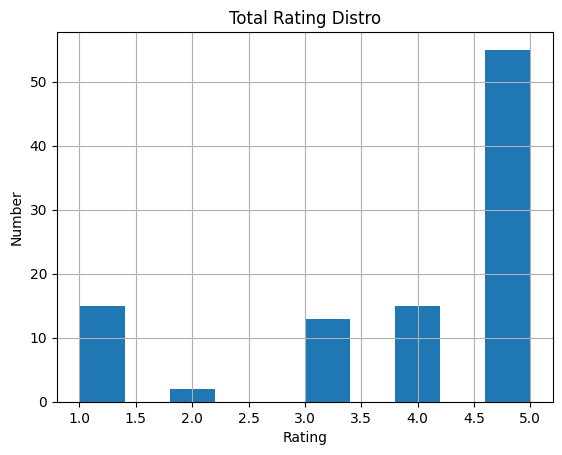

In [58]:
# Some exploratory visualization, let's check out the score distribution
df['rating'].hist()
plt.title('Total Rating Distro')
plt.xlabel('Rating')
plt.ylabel('Number')
plt.show()

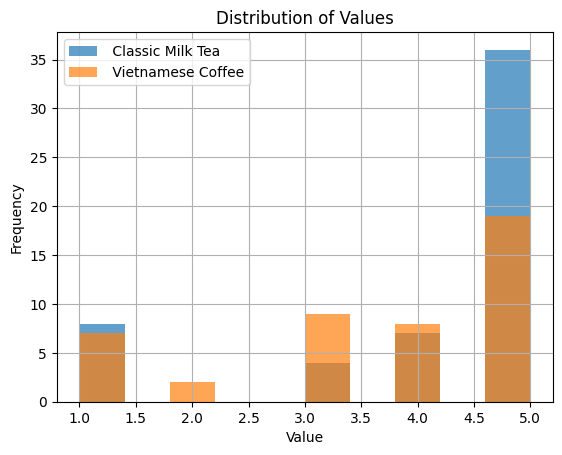

In [59]:
# Seeing the difference in score distro between Classic Milk Tea and Viet Coffee
df.groupby('Flavor')['rating'].hist(alpha=0.7, legend=True, bins=10)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

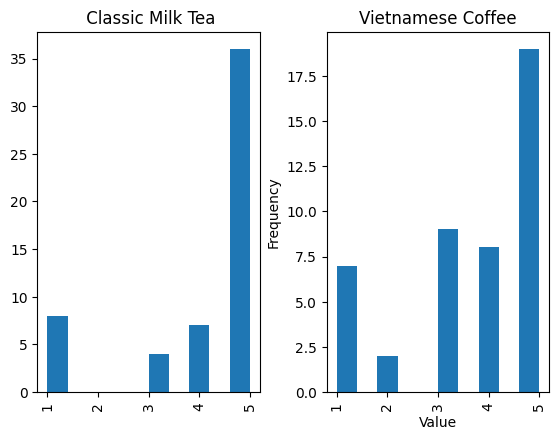

In [60]:
# Side by side score distro
df.hist(column='rating', by='Flavor')
plt.title('Vietnamese Coffee')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [61]:
# Classic Milk Tea seems to be a strong obvious choice with Viet Coffee being more controversial
# This further confirms what we did earlier with mean and median

In [62]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()

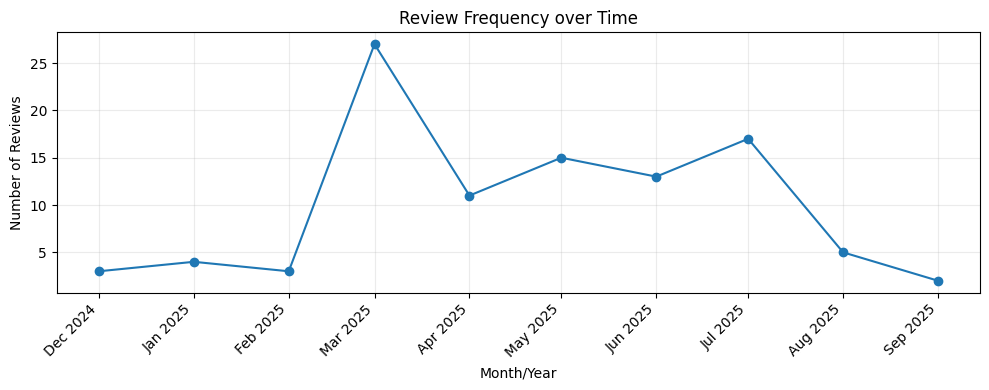

In [63]:
# Reviewing frequency over time
monthly_counts = (
    df.groupby("Month", as_index=False)
      .size()
      .rename(columns={"size": "reviews"})
      .sort_values("Month")
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(monthly_counts["Month"], monthly_counts["reviews"], marker="o")
ax.set_title("Review Frequency over Time")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Number of Reviews")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

In [64]:
# Consistent with my experience in CPG, we are seeing a big spike in March, possibly a promo or sale?
# In the summer we see some sort of sustained momentum, we do see a drop off in August which is also consistent with my experience in CPG 

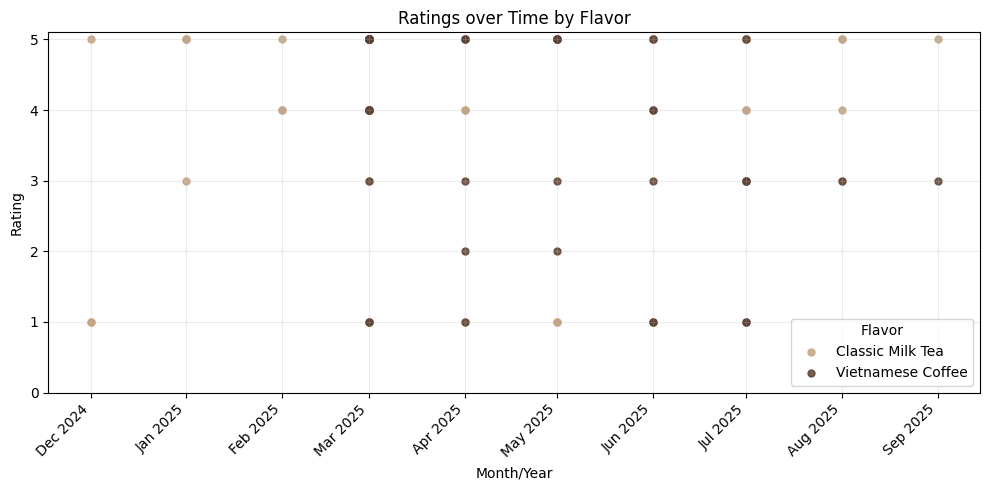

In [65]:
# Let's see if we can build a scatterplot to see if there is a relationship between time, ratings, and rating distribution

df = df.copy()

# Normalize Flavor (trim spaces/casing differences)
df["Flavor"] = df["Flavor"].astype(str).str.strip()

# Colors
light_brown = "#C4A484"   # Classic Milk Tea
dark_brown  = "#5C4033"   # Vietnamese Coffee
other_gray  = "#888888"

# Masks
m_classic = df["Flavor"].eq("Classic Milk Tea")
m_viet    = df["Flavor"].eq("Vietnamese Coffee")
m_other   = ~(m_classic | m_viet)

fig, ax = plt.subplots(figsize=(10, 5))
handles, labels = [], []

# Plot Classic Milk Tea
if m_classic.any():
    h1 = ax.scatter(df.loc[m_classic, "Month"], df.loc[m_classic, "rating"],
                    s=25, alpha=0.85, c=light_brown, label="Classic Milk Tea")
    handles.append(h1); labels.append("Classic Milk Tea")

# Plot Vietnamese Coffee
if m_viet.any():
    h2 = ax.scatter(df.loc[m_viet, "Month"], df.loc[m_viet, "rating"],
                    s=25, alpha=0.85, c=dark_brown, label="Vietnamese Coffee")
    handles.append(h2); labels.append("Vietnamese Coffee")

# Optionally show other flavors in gray so you don’t lose data
if m_other.any():
    h3 = ax.scatter(df.loc[m_other, "Month"], df.loc[m_other, "rating"],
                    s=20, alpha=0.5, c=other_gray, label="Other flavors")
    handles.append(h3); labels.append("Other flavors")

# Axes formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Rating")
ax.set_title("Ratings over Time by Flavor")
ax.set_ylim(0, 5.1)
ax.grid(True, alpha=0.25)

# Only draw legend if we actually plotted something
if handles:
    ax.legend(handles=handles, labels=labels, title="Flavor")

plt.tight_layout()
plt.show()

In [66]:
# Might be a swing and a miss but you got to take shots when necessary
# With the exception of a couple outliers, Classic Milk Tea scores consistently five stars over time 
# Viet coffee is much more spreadout in terms of rating (confirms finding from earlier)
# There does not seem to be  anoticable high point or low point in ratings

In [67]:
print(df.columns.tolist())

['asin', 'page', 'review_id', 'title', 'rating', 'author', 'date_text', 'body', 'verified_purchase', 'helpful_votes', 'variant', 'Flavor', 'Date', 'Month']


In [68]:
# Part 7 Sentiment Analysis
# Building Initial Sentiment Analyzer
text = (df["title"].fillna("") + ". " + df["body"].fillna("")).str.strip()
sia = SentimentIntensityAnalyzer()
sia.lexicon.update({
    "creamy": 2.0, "milky": 1.5, "aromatic": 1.8, "balanced": 1.5,
    "addictive": 1.2,  # positive terms for food
    "watery": -2.0, "chalky": -2.2, "chemical": -2.5, "cloying": -1.8,
    "overly": -0.7,  # negative terms for food
})
df["sent_compound"] = df["body"].fillna("").apply(lambda t: sia.polarity_scores(t)["compound"])
print(df["sent_compound"].describe())

count    100.000000
mean       0.632212
std        0.491642
min       -0.939300
25%        0.455900
50%        0.880450
75%        0.945325
max        0.993300
Name: sent_compound, dtype: float64


In [69]:
# So far it seems sentiment is positive for this Brand with the median score being 0.88. A few negative reviews do bring the mean score down

In [70]:
# thresholds from VADER paper
def to_label(c):
    if c >= 0.05: return "pos"
    if c <= -0.05: return "neg"
    return "neu"

df["sent_label"] = df["sent_compound"].apply(to_label)

# ensuring rating is numeric
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# quick sanity check: agreement between sentiment and rating bins
rating_label = pd.cut(df["rating"], bins=[0,2,3.5,5], labels=["low","mid","high"], include_lowest=True)
print(pd.crosstab(df["sent_label"], rating_label, normalize="columns").round(2))

# correlation
print("corr(sent_compound, rating) =", df[["sent_compound","rating"]].corr().iloc[0,1].round(3))

rating       low   mid  high
sent_label                  
neg         0.41  0.31   0.0
neu         0.06  0.08   0.0
pos         0.53  0.62   1.0
corr(sent_compound, rating) = 0.656


In [71]:
# Seeing how sentiment looks like on a monthly basis
monthly = (
    df.groupby("Month", as_index=False)
      .agg(reviews=("sent_compound", "size"),
           sent_mean=("sent_compound", "mean"),
           rating_mean=("rating", "mean"))
)

In [72]:
# quick look
print(monthly.tail(6))

       Month  reviews  sent_mean  rating_mean
4 2025-04-01       11   0.581700     3.636364
5 2025-05-01       15   0.651020     4.133333
6 2025-06-01       13   0.514931     3.769231
7 2025-07-01       17   0.459382     3.705882
8 2025-08-01        5   0.413180     4.000000
9 2025-09-01        2   0.816950     4.000000


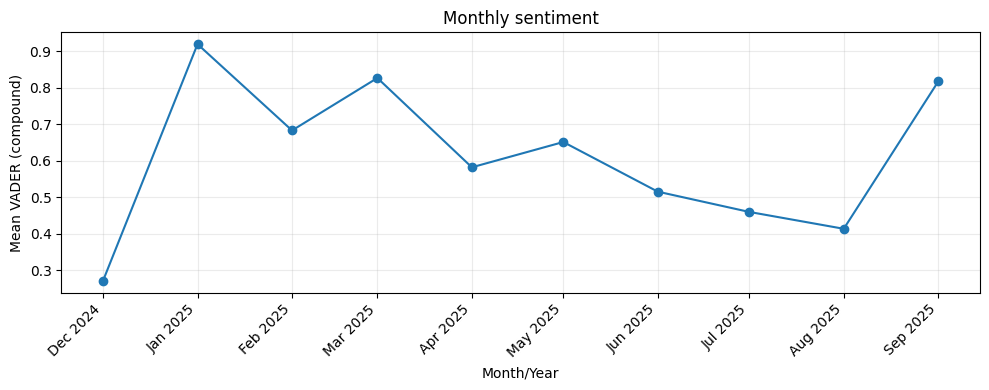

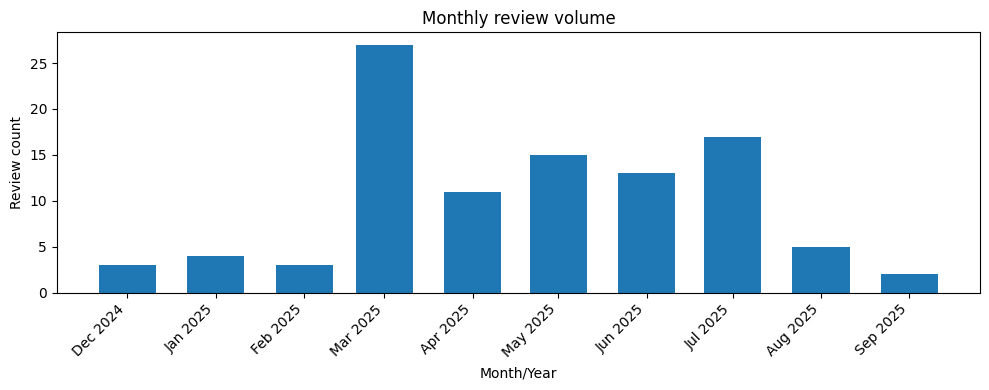

In [73]:
# Sentiment Plots
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(monthly["Month"], monthly["sent_mean"], marker="o")
ax1.set_ylabel("Mean VADER (compound)")
ax1.set_xlabel("Month/Year")
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
ax1.grid(True, alpha=0.25)
ax1.set_title("Monthly sentiment")

plt.tight_layout(); plt.show()

fig, ax2 = plt.subplots(figsize=(10,4))
ax2.bar(monthly["Month"], monthly["reviews"], width=20)  # bar for counts
ax2.set_ylabel("Review count")
ax2.set_xlabel("Month/Year")
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
ax2.set_title("Monthly review volume")
plt.tight_layout(); plt.show()

In [74]:
# Monthly Sentiment shifts month to month and reaches a high point in January 2025
# Perhaps these are enthusiastic early adopters or those encouraged by the Brand to leave positive reviews on AMZ to help boost Brand visibility
# Summer is where we see both increased review volume (implying increased sales overall?) but steadily declining Senitment
# Could this be due to more people trying out the Brand but not being convinced one way or another? or perhaps dissatisfaction on price or supply chain woes?

In [75]:
# Let us see if our conclusion changes when we split things (Classic Milk Tea vs Viet Coffee)
# I suspect it is Viet Coffee dragging down sentiment, especially in the summer. THis has been alludded to in our scatter plot earlier

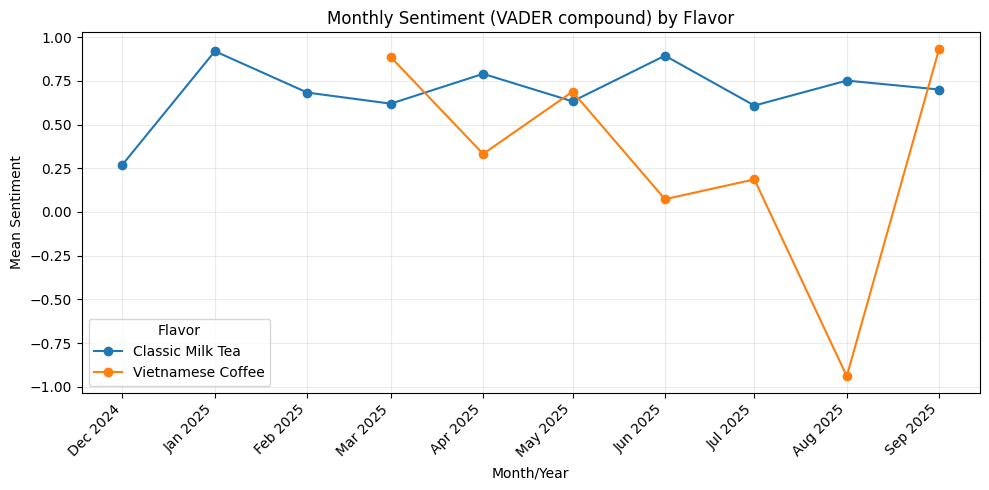

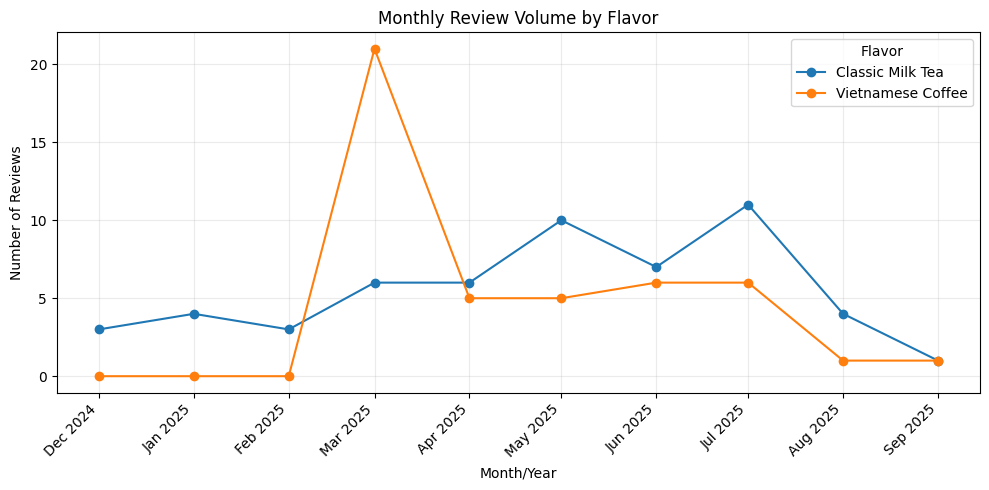

In [76]:
df = df.copy()
df["Flavor"] = df["Flavor"].astype(str).str.strip().replace({"": "Unknown"})
df["sent_compound"] = pd.to_numeric(df["sent_compound"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
if "Month" not in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])
    df["Month"] = df["Date"].dt.to_period("M").dt.to_timestamp()
flavor_monthly = (
    df.groupby(["Flavor", "Month"], as_index=False)
      .agg(
          reviews=("sent_compound", "size"),
          sent_mean=("sent_compound", "mean"),
          rating_mean=("rating", "mean"),
      )
      .sort_values(["Flavor", "Month"])
)
N = 2
top_flavors = (flavor_monthly.groupby("Flavor")["reviews"]
               .sum().sort_values(ascending=False).head(N).index.tolist())

fm = flavor_monthly[flavor_monthly["Flavor"].isin(top_flavors)].copy()
all_months = pd.date_range(fm["Month"].min(), fm["Month"].max(), freq="MS")  # Month Start
filled = []
for flv, g in fm.groupby("Flavor"):
    g = g.set_index("Month").reindex(all_months)
    g["Flavor"] = flv
    filled.append(g.reset_index().rename(columns={"index": "Month"}))
fm = pd.concat(filled, ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))

for flv, g in fm.groupby("Flavor"):
    ax.plot(g["Month"], g["sent_mean"], marker="o", label=flv)

ax.set_title("Monthly Sentiment (VADER compound) by Flavor")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Mean Sentiment")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
ax.grid(True, alpha=0.25)
ax.legend(title="Flavor")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

for flv, g in fm.groupby("Flavor"):
    ax.plot(g["Month"], g["reviews"].fillna(0), marker="o", label=flv)

ax.set_title("Monthly Review Volume by Flavor")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Number of Reviews")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
ax.grid(True, alpha=0.25)
ax.legend(title="Flavor")
plt.tight_layout()
plt.show()

In [ ]:
# The difference between Viet coffee and Classic Milk Tea is more astounding when we visualize the sentiment
# Classic Bubble Tea is the clear winner with it consitently scoring high on sentiment
# On this visual, we could definetly glean that viet coffee was maybe a launch item in March 2025 
# thus explaining the huge jump in reviews in March that we saw earlier
# June through August Viet Coffee scores lower on Sentiment thus bringing down the overall brand

In [ ]:
# Part 8 Word Cloud
# For fun, let's build a word cloud from the reviews, broken down by flavor, to gauge what people are saying about the Brand

In [77]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [94]:
df_wc = df.copy()

# Ensuring text fields & helpful votes present
df_wc["title"] = df_wc.get("title", "").fillna("")
df_wc["body"]  = df_wc.get("body", "").fillna("")
df_wc["helpful_votes"] = pd.to_numeric(df_wc.get("helpful_votes", 0), errors="coerce").fillna(0)

# Normalize flavor labels
df_wc["Flavor"] = df_wc["Flavor"].astype(str).str.strip()

# Text cleaning 
base_sw = set(STOPWORDS) | set(stopwords.words("english"))
domain_sw = {
    # product/amazon boilerplate & common filler
    "amazon","review","reviews","star","stars","product","purchase","purchased",
    "package","packaging","bag","bags","box","brand","price","money",
    # brand / category hints (adjust as needed)
    "milk","tea","milktea","classic","vietnamese","coffee","flavor","taste",
    "servings","size","ounces","oz","cup","cups","drink","drinks","boba","bubble",
    "mix","powder",
}
# Filtering out some words from our cloud
stop_set = {w.lower() for w in (base_sw | domain_sw)}
EXTRA_STOP = {
    "put", "company", "one", "think", "mixed", "protein", "water", "many", "whey", "one", "monk", "viet", "shake",      
    "buy", "bought", "purchasing", "purchas", "scoop", "really", "use", "used", "black", "see", "half", "make", "even",            
    "amzn", "asin", "http", "https", "fruit", "make",  
}
stop_set |= {w.lower() for w in EXTRA_STOP}
lemm = WordNetLemmatizer()
token_pat = re.compile(r"[a-zA-Z]+")

def tokenize_clean(text: str):
    # lower → keep letters → lemmatize → drop stopwords/short tokens
    toks = (t.lower() for t in token_pat.findall(text))
    toks = (lemm.lemmatize(t) for t in toks)
    toks = [t for t in toks if len(t) >= 3 and t not in stop_set]
    return toks

In [95]:
# Building weighted frequencies per flavor
def flavor_frequencies(df_slice: pd.DataFrame) -> dict[str, float]:
    freqs = Counter()
    for _, row in df_slice.iterrows():
        text = f"{row['title']} {row['body']}".strip()
        if not text:
            continue
        weight = float(row["helpful_votes"] + 1)  # +1 so unvoted reviews still count
        for tok in tokenize_clean(text):
            freqs[tok] += weight
    return dict(freqs)

# Choosing the two flavors explicitly
flavors_to_plot = ["Classic Milk Tea", "Vietnamese Coffee"]

freq_maps = []
for flv in flavors_to_plot:
    sub = df_wc[df_wc["Flavor"] == flv]
    freq_maps.append((flv, flavor_frequencies(sub)))

# Color functions (light vs dark brown)
def const_color(hex_color):
    def _inner(*args, **kwargs):
        return hex_color
    return _inner

light_brown = "#C4A484"  # Classic Milk Tea
dark_brown  = "#5C4033"  # Viet Coffee

color_funcs = {
    "Classic Milk Tea": const_color(light_brown),
    "Vietnamese Coffee": const_color(dark_brown),
}

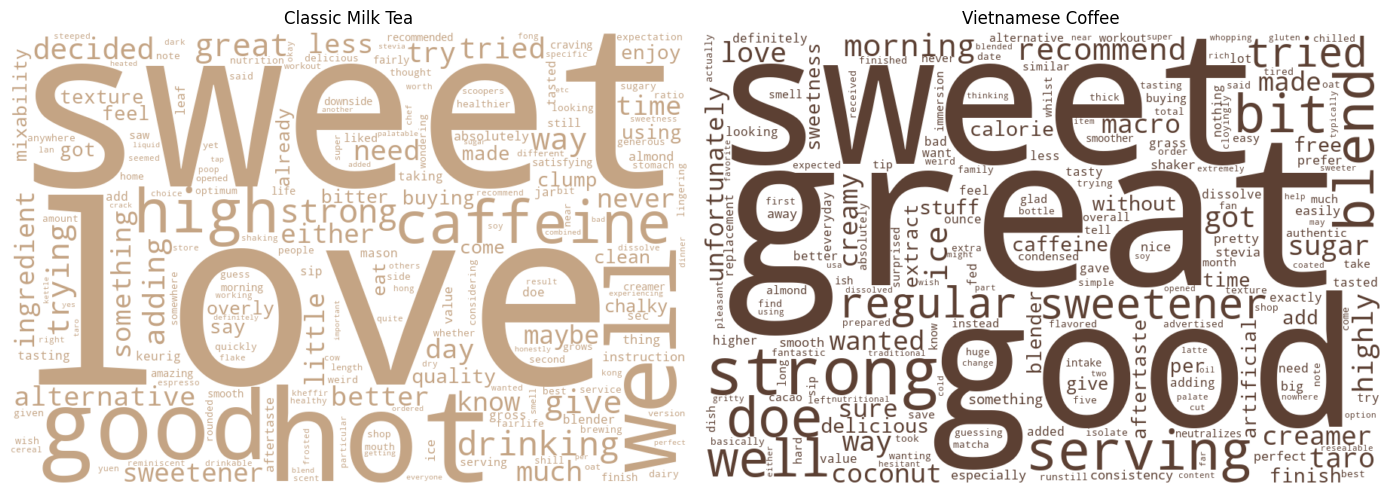

In [96]:
# Generate and plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, (flv, freqs) in zip(axes, freq_maps):
    if not freqs:
        ax.axis("off")
        ax.set_title(f"{flv} (no text)")
        continue

    wc = WordCloud(
        width=900, height=600,
        background_color="white",
        max_words=200,
        prefer_horizontal=0.9,
        collocations=False,  # keep “too sweet” as two tokens; set True if you like bigrams merged
        normalize_plurals=True,
    )
    wc = wc.generate_from_frequencies(freqs)
    # recolor to brand palette
    wc = wc.recolor(color_func=color_funcs.get(flv, const_color("#888888")))

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(flv)

plt.tight_layout()
plt.show()

In [ ]:
# A fun word cloud! After filtering some words out, we came to a more insightful word cloud
# CLassic Milk Tea comes out as expected with mostly positive words highlighted to us
# Viet coffee, despite the lower sentiment, has mostly positive words displayed. There are a couple negative words like "unfortantely", "artificial"
# Overall Brand sentiment is positive

In [97]:
# Saving our data with sentiment analysis
df.to_csv("amazon_reviews_with_sentiment.csv", index=False)

In [ ]:
# Conclusions
# From this small targetted analysis I can come to the conclusion that Boba Protein is a strong brand with some pull to it. 
# Their Classic Milk Tea scores high in sentiment and thus fosters an active and passionate community.
# Building community engagement is essential to small, niche, and up and coming Brands like these.
# Classic Milk Tea is a staple and should be pushed and supported to target consumers.
# Viet Coffee has room for improvement, the community passion is there, however there needs to be adjustments to the flavor if Viet Coffee is to perform.
# Viet Coffee could also suffer from competition at lower prices as there are many caffeineted coffee protein brands out there.
# By comparison, Classic Milk Tea's direct competition in the Protein space is far more limited.
# Classic Milk Tea also has the advantage of being more widely known as a bubble tea flavor.
# From our end analysis here, I can hypothesize how the other flavors from Boba Protein would do.
# I hypothesize Matcha will be a very popular flavor due to lack of competition in the protein space but also general awareness in the population (what is matcha).
# I hypothesize further that their other flavors like Jasmine Milk Tea, Taro, and Oolong will not sell as high of volume (less awareness) but still have a robust consumer base.
# Over the last 20 years, I have seen how flavors associated with Asian Gastronomy have slowly taken root in the US. 
# When I was growing up, I remember Boba being seen as "exotic" even in San Francisco and how nobody knew Matcha. Now it seems everybody knows Boba and Matcha.
# As these Asian flavors continue to take root, the potential consumer base for Boba Protein will only increase albiet at a slow/steady rate.
# The biggest threat I see for the Brand is price, as many other Brands are priced far lower. In this economy, this matters. 
# For now, I think the strategy should be to continue to push Classic Milk Tea, build the community, make adjustments to Viet Coffee, and overall stay competitive.

In [103]:
# weighted monthly sentiment (incomplete)

# making sure these are numeric 
df["sent_compound"] = pd.to_numeric(df["sent_compound"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# weights: +1 keeping unvoted reviews, align by index later
w = (df["helpful_votes"].fillna(0) + 1)

def wavg(x, wts):
    # align weights to x's index, drop rows where x is NaN or weight<=0
    wts = wts.reindex(x.index).fillna(0)
    x = pd.to_numeric(x, errors="coerce")
    mask = x.notna() & (wts > 0)
    if not mask.any():
        return np.nan
    return (x[mask] * wts[mask]).sum() / wts[mask].sum()

monthly = (
    df.groupby("Month")
      .apply(lambda g: pd.Series({
          "reviews": len(g),
          "sent_mean": wavg(g["sent_compound"], w),
          "rating_mean": wavg(g["rating"], w),
      }))
      .reset_index()
)

ValueError: cannot reindex on an axis with duplicate labels